In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
import cv2

def load_data_by_scene(data_dir):
    # 初始化存储每个场景数据的列表
    scenes_left_inputs = []
    scenes_right_inputs = []
    scenes_left_targets = []
    scenes_right_targets = []
    
    image_dir = data_dir
    
    # 遍历每个场景文件夹（如 000, 001, ...）
    for folder in sorted(os.listdir(image_dir)):
        folder_path = os.path.join(image_dir, folder)
        images = sorted(os.listdir(folder_path))
        # 标志变量，确保只读取一张噪声图像
        left_noise_read = False
        right_noise_read = False

        # 当前场景的输入数据
        left_inputs = []
        right_inputs = []
        
        # 遍历场景文件夹中的图片
        for img in images:
            img_path = os.path.join(folder_path, img)
            
            # 区分左右相机的真实图像和噪声图像
            if img == '000_0.png':  # 左相机真实图像
                left_target = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            elif img == '000_1.png':  # 右相机真实图像
                right_target = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            elif img.endswith('_0.png'):  # 左相机噪声图像
                left_inputs.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
                left_noise_read = True  # 标记为已读取
    
            elif img.endswith('_1.png'):  # 右相机噪声图像
                right_inputs.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
                right_noise_read = True  # 标记为已读取
            
            # 如果左右噪声图像都已读取，提前结束循环
            if left_noise_read and right_noise_read:
                break
        
        # 将当前场景数据添加到场景列表中
        scenes_left_inputs.append(left_inputs)
        scenes_right_inputs.append(right_inputs)
        scenes_left_targets.append(left_target)
        scenes_right_targets.append(right_target)

    return scenes_left_inputs, scenes_right_inputs, scenes_left_targets, scenes_right_targets

# 调用函数加载数据
data_path = "../data"
train_left_inputs, train_right_inputs, train_left_targets, train_right_targets = load_data_by_scene(os.path.join(data_path, "train/image"))
test_left_inputs, test_right_inputs, test_left_targets, test_right_targets = load_data_by_scene(os.path.join(data_path,"test"))

In [3]:
# 展平嵌套列表并匹配目标
def flatten_data(inputs, targets):
    flat_inputs = []
    flat_targets = []
    for scene_inputs, target in zip(inputs, targets):
        for img in scene_inputs:
            flat_inputs.append(img)  # 展平嵌套输入
            flat_targets.append(target)  # 将目标匹配到每张输入图像
    return flat_inputs, flat_targets

# 处理训练数据
flat_train_left_inputs, flat_train_left_targets = flatten_data(train_left_inputs, train_left_targets)
flat_train_right_inputs, flat_train_right_targets = flatten_data(train_right_inputs, train_right_targets)
flat_test_left_inputs, flat_test_left_targets = flatten_data(test_left_inputs, test_left_targets)
flat_test_right_inputs, flat_test_right_targets = flatten_data(test_right_inputs, test_left_inputs)

# 验证展平后的长度
print(len(flat_train_left_inputs))  
print(len(flat_test_left_targets))  
print(flat_train_left_inputs[0].shape)
print(flat_train_left_targets[0].shape)

100
10
(336, 624)
(336, 624)


In [6]:
def load_disparity_and_mask(data_dir):
    """加载视差图和掩膜图"""
    disparities = []
    disparities_r = []
    masks = []
    masks_r = []
    
    image_dir = os.path.join(data_dir, 'image')
    mask_dir = os.path.join(data_dir, 'mask')
    mask_r_dir = os.path.join(data_dir, 'mask_r')
    disparity_dir = os.path.join(data_dir, 'disparity')
    disparity_r_dir = os.path.join(data_dir, 'disparity_r')
    
    for folder in sorted(os.listdir(image_dir)):
        # 加载掩膜和视差图
        mask = cv2.imread(os.path.join(mask_dir, f"{folder}.png"), cv2.IMREAD_GRAYSCALE)
        mask_r = cv2.imread(os.path.join(mask_r_dir, f"{folder}.png"), cv2.IMREAD_GRAYSCALE)
        disparity = cv2.imread(os.path.join(disparity_dir, f"{folder}.png"), cv2.IMREAD_GRAYSCALE)
        disparity_r = cv2.imread(os.path.join(disparity_r_dir, f"{folder}.png"), cv2.IMREAD_GRAYSCALE)

        masks.append(mask)
        masks_r.append(mask_r)
        disparities.append(disparity)
        disparities_r.append(disparity_r)

    return disparities, disparities_r, masks, masks_r

data_path = "../data/train"
disparities, disparities_r, masks, masks_r = load_disparity_and_mask(data_path)

In [5]:
print(disparities[0].shape)
print(len(disparities))
print(disparities_r[0].shape)

(336, 624)
100
(336, 624)


Text(0.5, 1.0, 'target_left')

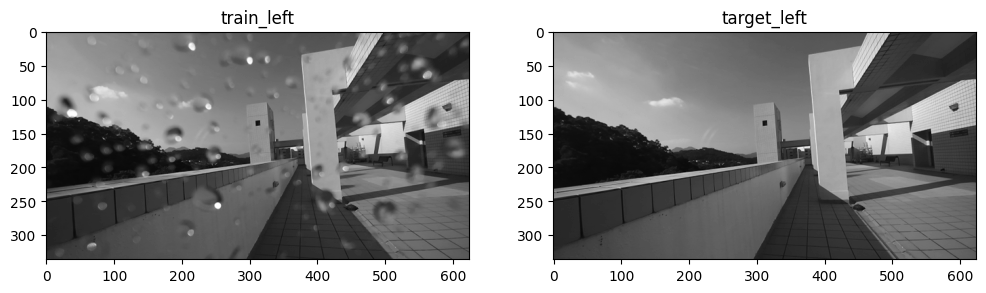

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(flat_test_left_inputs[1],cmap='gray')
plt.title("train_left")
plt.subplot(1,2,2)
plt.imshow(flat_test_left_targets[1],cmap='gray')
plt.title("target_left")

In [8]:
class StereoDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # 将图像转换为 Tensor，并标准化
        input_img = torch.tensor(self.inputs[idx], dtype=torch.float32).unsqueeze(0) / 255.0
        target_img = torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0) / 255.0
        return input_img, target_img

# 创建训练和测试集
train_dataset = StereoDataset(flat_train_left_inputs, flat_train_left_targets)
test_dataset = StereoDataset(flat_test_left_inputs, flat_test_left_targets)

In [9]:
class StereoDataset1(Dataset):
    def __init__(self, inputs, targets, disparities, disparities_r, masks, masks_r):
        self.inputs = inputs
        self.targets = targets
        self.disp = disparities
        self.disp_r = disparities_r
        self.mask = masks
        self.mask_r = masks_r

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # 输入图像和目标图像
        input_img = torch.tensor(self.inputs[idx], dtype=torch.float32).unsqueeze(0) / 255.0
        target_img = torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0) / 255.0

        # 深度信息和掩码
        disparity = torch.tensor(self.disp[idx], dtype=torch.float32).unsqueeze(0)
        disparity_r = torch.tensor(self.disp_r[idx], dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(self.mask[idx], dtype=torch.float32).unsqueeze(0)
        mask_r = torch.tensor(self.mask_r[idx], dtype=torch.float32).unsqueeze(0)

        return input_img, target_img, disparity, disparity_r, mask, mask_r
train_dataset = StereoDataset1(flat_train_left_inputs, flat_train_left_targets,disparities, disparities_r, masks, masks_r)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
for inputs, targets, disparity, disparity_r, mask, mask_r in train_loader:
    print(inputs.shape)  # (batch_size, 1, 336, 624)
    print(targets.shape)  # (batch_size, 1, 336, 624)
    print(disparity.shape)  # 视差图的形状
    break

torch.Size([16, 1, 336, 624])
torch.Size([16, 1, 336, 624])
torch.Size([16, 1, 336, 624])
